In [1]:
!pip install mdtraj

  Using cached mdtraj-1.9.7-cp38-cp38-linux_x86_64.whl


In [3]:
%pylab inline

import mdtraj
import thor
from thor import scatter

Populating the interactive namespace from numpy and matplotlib


In [86]:
# # I recommend putting your model in P1
traj = mdtraj.load('3LYZ.pdb')

In [22]:
!wget https://raw.githubusercontent.com/mdtraj/mdtraj/master/tests/data/tip3p_300K_1ATM.pdb

--2022-08-02 19:20:27--  https://raw.githubusercontent.com/mdtraj/mdtraj/master/tests/data/tip3p_300K_1ATM.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62866 (61K) [text/plain]
Saving to: ‘tip3p_300K_1ATM.pdb’

tip3p_300K_1ATM.pdb 100%[===================>]  61.39K  --.-KB/s    in 0.001s  

2022-08-02 19:20:27 (45.9 MB/s) - ‘tip3p_300K_1ATM.pdb’ saved [62866/62866]



In [98]:
traj = mdtraj.load('tip3p_300K_1ATM.pdb')

In [99]:
# this code is not special, there may be a better way
# what you need is the q_xyz corresponding to each hkl
# you want to compute

hkl_grid = mgrid[-11:12,-11:12,-11:12]

# this is a matrix of a*, b*, c*
recip_latt_matrix = np.array([[1., 0., 0.],
                              [0., 1., 0.],
                              [0., 0., 1.]])

q_values = np.dot(hkl_grid.T, recip_latt_matrix)

q_values = q_values.reshape(-1, 3)

# at the end of the day, you need a 2D array "q_values"
# that is N x 3 in size. N = total number of hkls, 3 = {x,y,z}
# we will compute the intensity at this location in recip. space

print (q_values.shape)

(12167, 3)


In [100]:
num_molecules = 1
detector = q_values

amplitudes = scatter.simulate_atomic(traj, num_molecules, detector,
                                     finite_photon=False, ignore_hydrogens=True,
                                     dont_rotate=True)

# also check out scatter.simulate_density

CPU Thread 0 :: 1 shots


In [101]:
intensities = np.real(np.square(amplitudes))
print (intensities.shape)

(12167,)


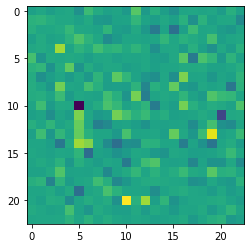

In [102]:
I = intensities.reshape(23,23,23)
imshow(I[0,:,:], interpolation='nearest')

In [103]:
# as an exercise, let's compute a continuous diffraction pattern
# like we would see on a detector at a beamline!

dtc = thor.Detector.generic(l=150)
print (dtc.reciprocal) # this is the same as "q_values" above

[[-2.45820464 -2.45820464 -1.38041173]
 [-2.46398002 -2.43934022 -1.37174866]
 [-2.46973764 -2.42034288 -1.36311223]
 ...
 [ 2.46973764  2.42034288 -1.36311223]
 [ 2.46398002  2.43934022 -1.37174866]
 [ 2.45820464  2.45820464 -1.38041173]]


In [104]:
amplitudes = scatter.simulate_atomic(traj, num_molecules, dtc.reciprocal,
                                     finite_photon=False, ignore_hydrogens=True,
                                     dont_rotate=True)
I = np.abs(np.square(amplitudes))
print (I.shape)


CPU Thread 0 :: 1 shots
(40401,)


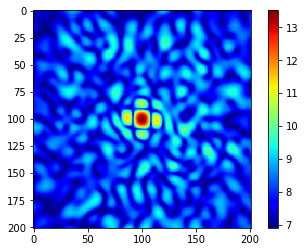

In [116]:
imshow(np.log(1000 + I.reshape(201,201)), interpolation='nearest', cmap = 'jet')
plt.colorbar()

In [58]:
from xrdc.source_separation import *

In [107]:
II = I.reshape(201,201)

In [108]:
IIft = fft2(I.reshape(201,201))

In [117]:
ift_amp = np.sqrt(power(np.sqrt(IIft)))

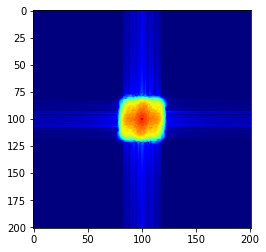

In [118]:
plt.imshow(np.log(100000 + fftshift(np.sqrt(power(IIft)))), cmap = 'jet')

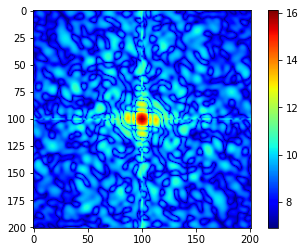

In [120]:
plt.imshow(np.log(1000 + fftshift(np.sqrt(power(fft2(ift_amp))))), cmap = 'jet')
plt.colorbar()

In [41]:
from xrdc import fourier
from xrdc.source_separation import *

In [2]:
N = 101
arr = np.zeros((N, N))

In [3]:
def mk_noise():
    return np.random.uniform(size = N * N).reshape(N, N)

In [29]:
def mk_real():
    #return np.pad(gf(mk_noise(), .7), N // 2)
    return np.pad(gf(mk_noise() + draw_circles(10, N), .7), N // 2)
    #return np.pad(draw_circle(arr, 3).copy() + mk_noise(), 10)

In [262]:
N = 101

In [263]:
def roll2d(arr, shiftx, shifty):
    return np.roll(np.roll(arr, shiftx).T,
                  shifty).T

In [264]:
def draw_circles(n, N):
    arr = np.zeros((N, N))
    circles = [draw_circle(arr, np.random.uniform() * 10).copy() for _ in range(n)]
    circles = list(map(lambda circ: roll2d(circ,  int(-.4 * N + 0.8 * N * np.random.uniform()),
                                                     int(-.4 * N + .8 * N * np.random.uniform())
                                           ),
                      circles))
    from functools import reduce
    return np.heaviside(reduce(lambda a, b: a + b, circles), 0)

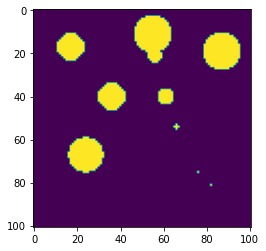

In [265]:
plt.imshow(draw_circles(10, N))

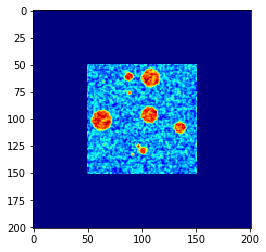

In [266]:
x = mk_real()

#mpl.rcParams['figure.figsize'] =(4,4)

plt.imshow(x, interpolation = 'none', cmap = 'jet')

In [271]:
epsilon = 1e-2

off = np.zeros_like(x)
i, j = 75, 82
off[i, j] = epsilon
off += epsilon / (off.size)

off2 = np.zeros_like(x)
off2[i, j + 1] = epsilon
off2 += epsilon / (off2.size)

y = fftshift(np.sqrt(power(fft2(x))))

yphase = fftshift((np.angle(fft2(x))))

ydelt = fftshift(np.sqrt(power(fft2(x + off))))
ydelt2 = fftshift(np.sqrt(power(fft2(x + off2))))

ydelt_phase = fftshift((np.angle(fft2(x + off))))

In [269]:
sq1d = np.abs(fftshift(fourier.fftfreq(len(yphase)))) <= .25
sq2d = np.einsum('i,j->ij', sq1d, sq1d)

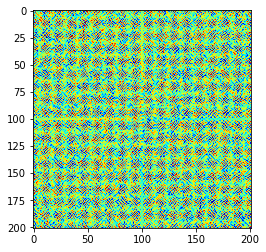

In [57]:
plt.imshow(yphase, cmap= 'jet')

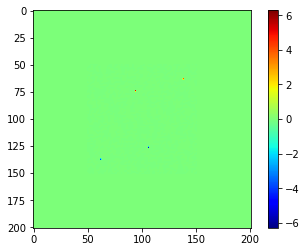

In [58]:
plt.imshow((ydelt_phase - yphase) * sq2d, cmap = 'jet')
plt.colorbar()

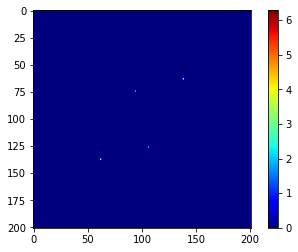

In [59]:
plt.imshow((np.abs(ydelt_phase - yphase) + .001) * sq2d, cmap = 'jet')
plt.colorbar()

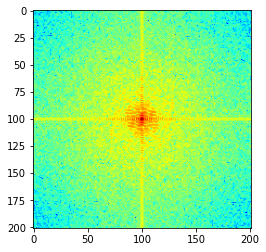

In [60]:
plt.imshow(np.log(y), cmap = 'jet')

In [48]:
recon = fftshift(ifft(ifftshift(y)))

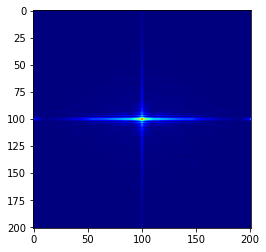

In [49]:
plt.imshow(np.sqrt(power(recon)), cmap = 'jet')

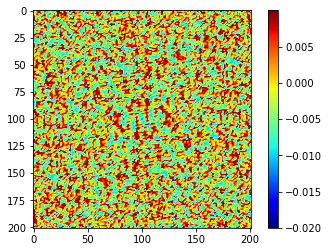

In [61]:
plt.imshow((y - ydelt), cmap = 'jet')
plt.colorbar()

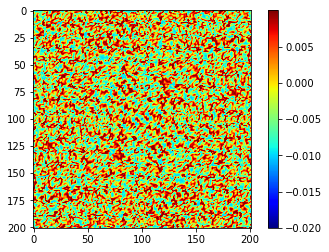

In [272]:
plt.imshow((y - ydelt2), cmap = 'jet')
plt.colorbar()

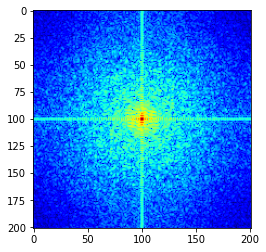

In [67]:
plt.imshow(np.log(1 + y), cmap = 'jet')

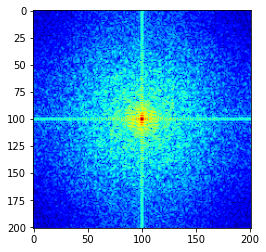

In [65]:
plt.imshow(np.log(1 + ydelt), cmap = 'jet')

In [ ]:
plt.imshow(np.log(y), cmap = 'jet')

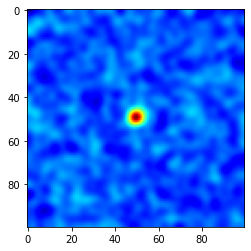

In [150]:
plt.imshow(, cmap = 'jet')

mark

In [156]:
from tensorflow.signal import fft

from tensorflow.keras.layers import Lambda
from tensorflow.signal import fft, fft2d, fftshift, ifft2d, ifft2d

import tensorflow

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# from skimage.transform import resize

from xrdc.source_separation import *
from skimage.transform import resize
from tensorflow.signal import fft2d, fftshift

N = 28

# def do_resize(x):
#     padx = pady = N // 2
#     transform = tf.keras.layers.AveragePooling2D((2, 2))
#     padder = tf.keras.layers.ZeroPadding2D(padding = padx // 2)
#     res = tfk.Sequential([transform, padder])(x)
#     return res
# # #     resized = torch.nn.functional.pad(
# # #             transform(x) / 4
# # # #             resize(x, newshape)
# # #         , p2d, "constant", 0)
# #     resized = padder(
# #         transform(x)
# #     )
# #     return resized

# def do_forward(x):
#     X = (fft2d(
#         tf.cast(do_resize(x), tf.complex64)
#     )) 
#     psd = tf.cast(tf.math.real(tf.math.conj(X) * X) / N**2, tf.float32)
    
#     #return psd
#     amplitude = tf.math.sqrt(fftshift(psd, (-1, -2)))
#     return amplitude
#     #return amplitude / torch.max(torch.max(amplitude, dim = -1).values, dim = -1).values[:, None, None]
    
padx = pady = N // 2
def do_resize():
    #padx = pady = x.shape[1] // 2
    transform = tfkl.AveragePooling2D(2)
    padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))
    return tfk.Sequential([
        transform,
        padder
    ])

def do_forward():
    sequential = do_resize()
    sequential.add(Lambda(lambda resized: (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))
                                                      ), 3)
                         ))
    return sequential

def resize(x):
    rmod = do_resize()
    rmod.compile(loss = 'mse')
    return rmod.predict(x)

rmod = do_forward()
rmod.compile(loss='mse')
#rmod.fit(x, x)

In [ ]:
# def do_resize():
#     #padx = pady = x.shape[1] // 2
#     transform = tfkl.AveragePooling2D(2)
#     padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))
#     return tfk.Sequential([
#         tfkl.AveragePooling2D(2),
#         tfkl.ZeroPadding2D((padx // 2, padx // 2)),
#         Lambda(lambda resized: (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))),
#         Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2),
#         Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                                       ), 3)
#                          )
#     ])

# def do_forward():
#     sequential = do_resize()
#     sequential.add(Lambda(lambda resized: (fft2d(
#         tf.squeeze(tf.cast(resized, tf.complex64))
#     ))))
#     sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
#     sequential.add(Lambda(lambda psd: 
#                           tf.expand_dims(
#                               tf.math.sqrt(
#             fftshift(psd, (-2, -1))
#                                                       ), 3)
#                          ))
#     return sequential

In [50]:
layer = Lambda(do_forward)

In [53]:
layer.apply(x)

/tmp/ipykernel_12876/3805821112.py:1: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  layer.apply(x)


ValueError: Exception encountered when calling layer "lambda_28" (type Lambda).


The following Variables were created within a Lambda layer (lambda_28)
but are not tracked by said layer:
  <tf.Variable 'lambda_28/Variable:0' shape=() dtype=int64, numpy=0>
  <tf.Variable 'lambda_28/Variable:0' shape=() dtype=int64, numpy=0>
  <tf.Variable 'lambda_28/Variable:0' shape=() dtype=int64, numpy=0>
The layer cannot safely ensure proper Variable reuse across multiple
calls, and consequently this behavior is disallowed for safety. Lambda
layers are not well suited to stateful computation; instead, writing a
subclassed Layer is the recommend way to define layers with
Variables.

Call arguments received:
  • inputs=tf.Tensor(shape=(10, 28, 28, 1), dtype=float32)
  • mask=None
  • training=False

In [42]:
from xrdc import fourier

In [104]:
rmod.predict(x).shape

(10, 28, 28, 1)

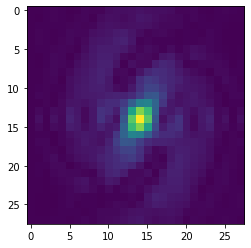

In [172]:
plt.imshow(((rmod.predict(x)[0].squeeze())))

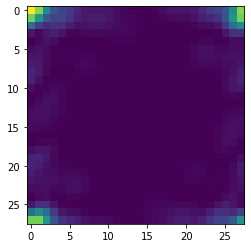

In [39]:
plt.imshow(power(fourier.ifft2(rmod.predict(x)[3].squeeze())))

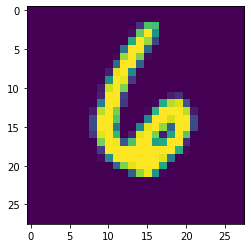

In [46]:
plt.imshow(np.array(x).squeeze()[0])

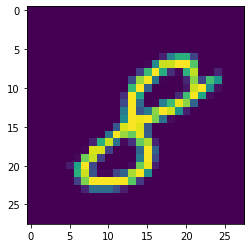

In [505]:
plt.imshow(np.array(x).squeeze()[3])

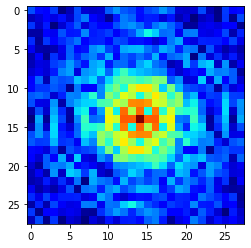

In [579]:
arg0 = fourier.fftshift(power(fourier.fft2((np.array(x).squeeze()[1]))))
plt.imshow(
    np.log(1 + arg0)
, cmap = 'jet')

In [667]:
tmp = ((fourier.fft2((np.array(x).squeeze()[1]))))

In [668]:
mask = (np.abs(fourier.fftfreq(28)) > .25)

In [662]:
tmp[mask, :] = 0

tmp[:, mask] = 0

from scipy.fftpack import ifftshift as sifftshift

In [669]:
tmp2 = (power(fourier.ifft2((tmp))))

In [670]:
tmp2.mean(), np.array(x).squeeze()[1].mean()

(0.22483566, 0.24898957)

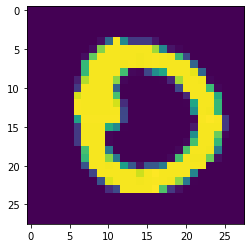

In [671]:
plt.imshow(tmp2)

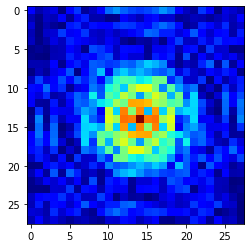

In [672]:
plt.imshow(np.log(4 + power(fourier.fftshift(fourier.fft2(tmp2)))), cmap = 'jet')

In [514]:
resize(x)

1/1 [==============================] - 0s 25ms/step - loss: 0.0000e+00


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00


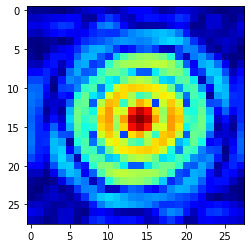

In [658]:
arg = fourier.fftshift(power(fourier.fft2((np.array(
        resize(x)
    ).squeeze()[1]))))
plt.imshow(
    np.log(1 + 
           arg
          )
, cmap = 'jet')

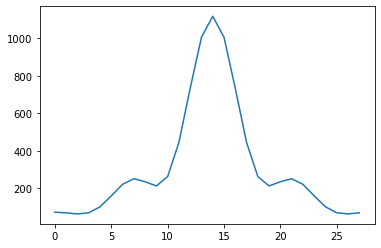

In [526]:
plt.plot(arg.sum(axis = 0))

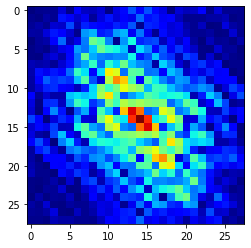

In [548]:
arg2 = fourier.fftshift(power(fourier.fft2((np.array(
        x
    ).squeeze()[3]))))
plt.imshow(
    np.log(4 + 
           arg2
          )
, cmap = 'jet')

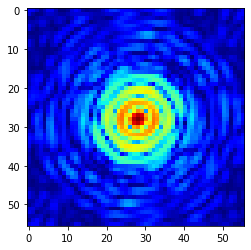

In [577]:
arg3 = fourier.fftshift(power(fourier.fft2(
    np.pad(np.array(x)[1].squeeze(), 14)
    )))

plt.imshow(
    np.log(4 + 
           arg3
          )
, cmap = 'jet')

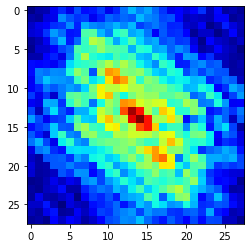

In [564]:
arg4 = arg3[0::2, 0::2] + arg3[0::2, 1::2] + arg3[1::2, 0::2] + arg3[1::2, 1::2]
plt.imshow(
    np.log(4 + 
           arg4
          )
, cmap = 'jet')

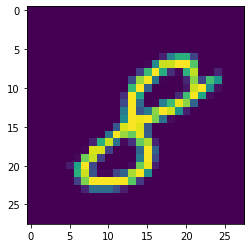

In [538]:
plt.imshow(np.array(x)[3].squeeze())

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00


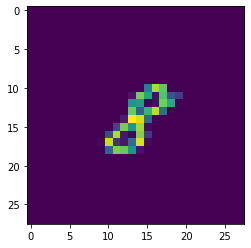

In [539]:
plt.imshow(np.array(resize(x))[3].squeeze())

In [535]:
np.sum(x)

1248.9922

In [533]:
np.sum(resize(x))

1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00


312.24805

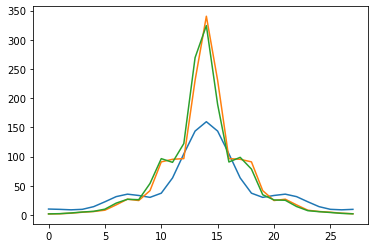

In [561]:
plt.plot(4 * arg.mean(axis = 0))
plt.plot(arg2.mean(axis = 0))
# plt.plot(arg3.mean(axis = 0))
plt.plot(arg4.mean(axis = 0) / 4)

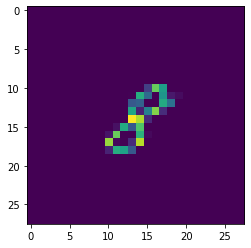

In [484]:
plt.imshow(power(np.array(rmod.predict(x)[3]).squeeze()))

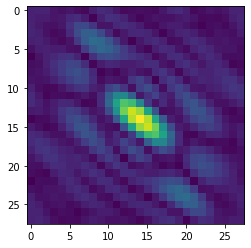

In [487]:
plt.imshow((np.array(rmod.predict(x)[3]).squeeze()))

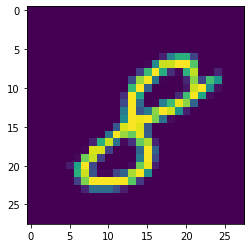

In [394]:
plt.imshow(np.array(x[3]).squeeze())

In [6]:
import torch

In [7]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)

KeyError: 'cuda_version'

In [8]:
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)

KeyError: 'cudnn_version'

In [9]:
# tf.debugging.set_log_device_placement(False)

In [128]:
datasets['train']

<_OptionsDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [263]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
#     image = tf.squeeze(
#         do_forward(
#             image[None, ...]),
#         axis = 0)
    #image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    #image = tf.expand_dims(image, 0)
    #print(image.shape)

    rmod = do_forward()
    rmod.compile(loss='mse')
    image = rmod(image)#rmod.predict(image)
    return image, None

train_dataset = (datasets['train']
                 .batch(256)
                 .map(_preprocess)
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .batch(256)
                .map(_preprocess)
                .prefetch(tf.data.AUTOTUNE))

In [264]:
x = next(iter(eval_dataset))[0][:10]


In [7]:
x.shape

TensorShape([10, 28, 28, 1])

In [8]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [63]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

# encoder = tfk.Sequential([
#     tfkl.InputLayer(input_shape=input_shape),
#     tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
#     tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(base_depth, 5, strides=1,
#                 padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2D(base_depth, 5, strides=2,
#                 padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2D(2 * base_depth, 5, strides=1,
#                 padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2D(2 * base_depth, 5, strides=2,
#                 padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2D(4 * encoded_size, 7, strides=1,
#                 padding='valid', activation=tf.nn.leaky_relu),
#     tfkl.Flatten(),
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
#                activation=None),
#     tfpl.MultivariateNormalTriL(
#         encoded_size,
#         activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
    
    
#     tfkl.Reshape([1, 1, encoded_size]),
#     tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
#                          padding='valid', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=2,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2DTranspose(base_depth, 5, strides=1,
#                          padding='same', activation=tf.nn.leaky_relu),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
#     tf.keras.layers.BatchNormalization(),
#     tfkl.Reshape(input_shape),
#     do_forward(),
# ])

In [262]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    #tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation(activation='sigmoid'),
#     Lambda(lambda x: x * 2),
    tfkl.Reshape(input_shape),
    
     #tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.01))),
])

decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
    do_forward(),
#     tfkl.AveragePooling2D(2),
#     tfkl.ZeroPadding2D((padx // 2, padx // 2)),
#     Lambda(lambda resized: (fft2d(
#     tf.squeeze(tf.cast(resized, tf.complex64))
# ))),
#     Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2),
#     Lambda(lambda psd: 
#               tf.expand_dims(
#                   tf.math.sqrt(
#                         fftshift(psd, (-2, -1))), 3)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.01))),
])


    #tfkl.Flatten(),
#     tfpl.IndependentNormal(784),
#    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.01)))
     #tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),

# decoder = tfk.Sequential([
#     tfkl.InputLayer(),    
#      tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.01))),
# ])

#     tfkl.AveragePooling2D(2),
#     tfkl.ZeroPadding2D((padx // 2, padx // 2)),
#     Lambda(lambda resized: (fft2d(
#     tf.squeeze(tf.cast(resized, tf.complex64))
# ))),
#     Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2),
#     Lambda(lambda psd: 
#                       tf.expand_dims(
#                           tf.math.sqrt(
#                                 fftshift(psd, (-2, -1))), 3)),

In [220]:
# plt.hist(np.array(x[3]).ravel())

In [221]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [222]:
for layer in decoder.layers:
    print(layer.output_shape)

(None, 1, 1, 16)
(None, 1, 1, 16)
(None, 7, 7, 64)
(None, 7, 7, 64)
(None, 14, 14, 64)
(None, 14, 14, 32)
(None, 28, 28, 32)
(None, 28, 28, 32)
(None, 28, 28, 1)
(None, 28, 28, 1)


In [223]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negloglik)

In [224]:
_ = vae.fit(train_dataset,
            epochs=1,
            validation_data=eval_dataset)

235/235 [==============================] - 168s 674ms/step - loss: 10731.6064 - val_loss: 4986.3594


In [221]:
vae.layers[-1].layers[-2].layers[-1].output

<KerasTensor: shape=<unknown> dtype=float32 (created by layer 'lambda_50')>

In [274]:
vae.layers[-1].get_output_at(1)

ValueError: Asked to get output at node 1, but the layer has only 1 inbound nodes.

In [76]:
decoder.layers

In [78]:
inputs = [encoder.input] 
outputs = [decoder.layers[-1]]
#outputs = [vae.layers[-1].layers[0].get_output_at(0)]
#outputs = [vae.layers[-1].layers[-2].layers[-1].output]
#functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]
model = tf.keras.Model(inputs, outputs)

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <keras.engine.sequential.Sequential object at 0x7f832ea10820>

In [61]:
vae.layers[-1].layers

In [282]:
vae.layers[-1].layers[0].name

'reshape_12'

In [249]:
import keras

In [252]:
!pip install pydot

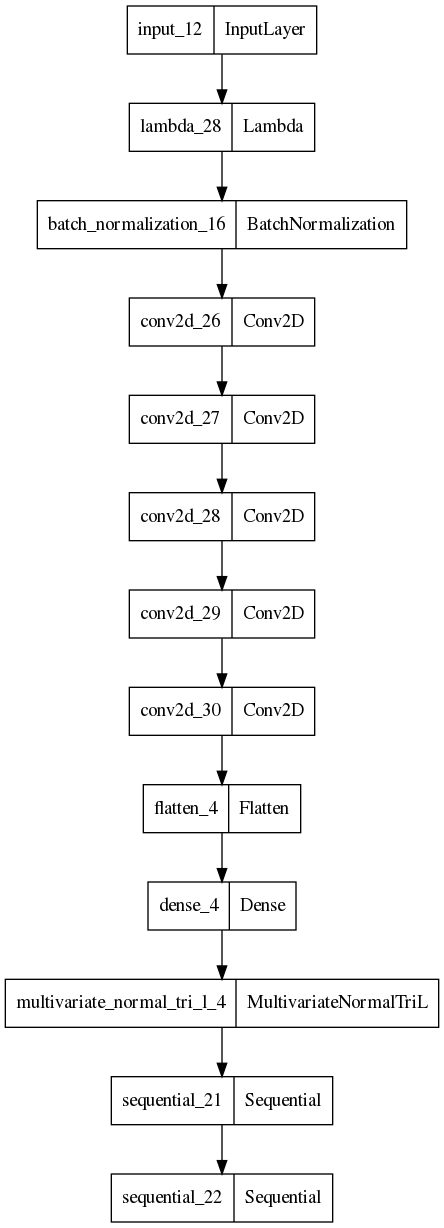

In [89]:
tf.keras.utils.plot_model(vae, 'foo.png')

In [265]:
vae.layers[-1].layers[0]

In [227]:
outputs

[<KerasTensor: shape=<unknown> dtype=float32 (created by layer 'lambda_50')>]

In [235]:
# from keras import backend as K
# OutFunc = K.function([vae.input], [vae.layers[-1].layers[-2].layers[-1].output])

In [215]:
vae.layers[-1].layers[-1]

In [200]:
print(tf.config.list_physical_devices('GPU'))

[]


In [183]:
# tmp1, tmp2 = x, xhat

In [225]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [226]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

In [186]:
# print('Originals:')
# display_imgs(x)

# print('Decoded Random Samples:')
# display_imgs(xhat.sample())

# print('Decoded Modes:')
# display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

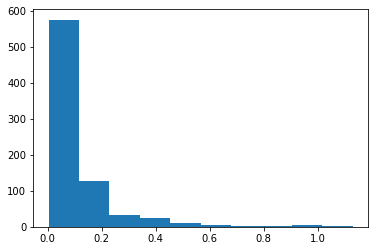

In [187]:
plt.hist(np.array(tf.squeeze(x[5])).ravel());

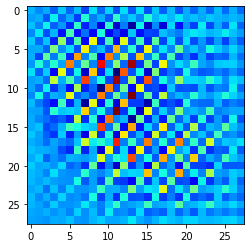

In [167]:
plt.imshow(np.array((decoder(encoder(x)))).squeeze()[4], cmap = 'jet')

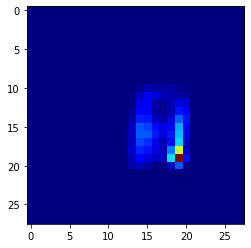

In [256]:
plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[7], cmap = 'jet')

In [238]:
np.array(resize(decoder(encoder(x)))).squeeze()[7].max()

2.3091733

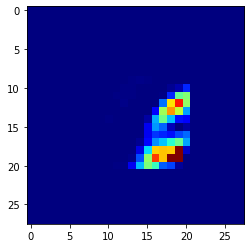

In [261]:
plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[1], cmap = 'jet', vmax = .7)

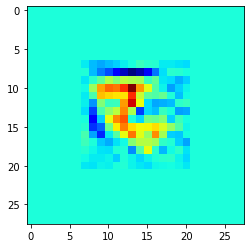

In [166]:
plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[4], cmap = 'jet') # with batch normalization

In [169]:
np.array((decoder(encoder(x)))).squeeze().min()

-1.8915594

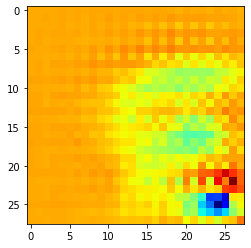

In [198]:
plt.imshow(np.array((decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

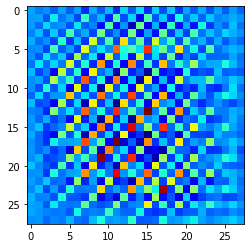

In [153]:
plt.imshow(np.array((decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

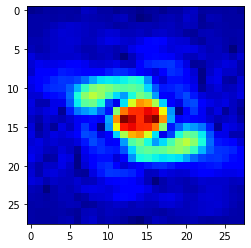

In [148]:
plt.imshow(np.array(decoder2(decoder(encoder(x))).mean()).squeeze()[0], cmap = 'jet')

Originals:


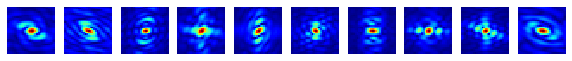

Decoded Random Samples:


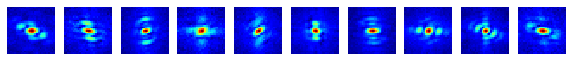

Decoded Modes:


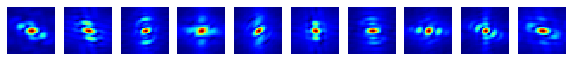

Decoded Means:


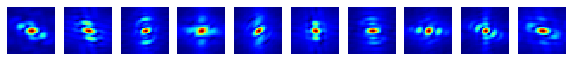

In [239]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

Originals:


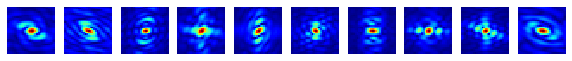

Decoded Random Samples:


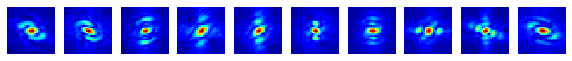

Decoded Modes:


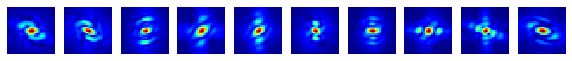

Decoded Means:


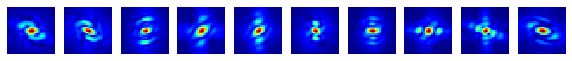

In [206]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

Originals:


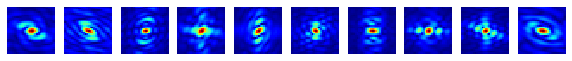

Decoded Random Samples:


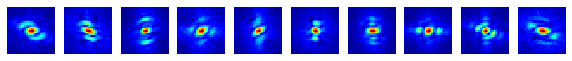

Decoded Modes:


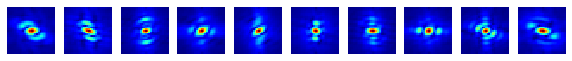

Decoded Means:


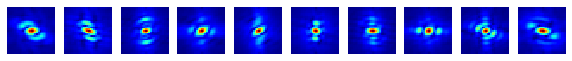

In [197]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [150]:
np.max(xhat.mean())

0.91070217

Randomly Generated Samples:


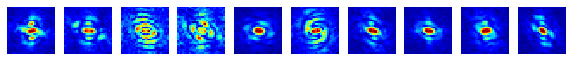

Randomly Generated Modes:


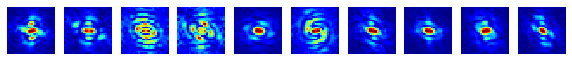

Randomly Generated Means:


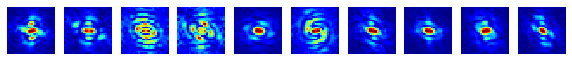

In [151]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

Randomly Generated Samples:


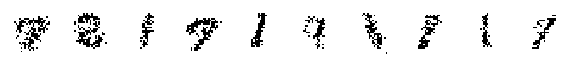

Randomly Generated Modes:


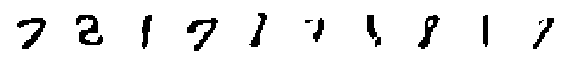

Randomly Generated Means:


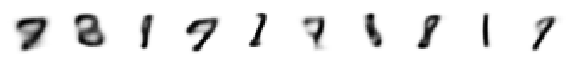

In [455]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

In [522]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [523]:
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [542]:
do_forward(nn.ZeroPad2d((0, 1, 0, 1))(x)).shape

torch.Size([16, 1, 29, 29])

In [543]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.Compose([transforms.ToTensor(),
                                nn.ZeroPad2d((0, 1, 0, 1)),
                                do_forward])
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [544]:
import torchvision

In [586]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.z_dim = z_dim
        
        base_depth = 32
        
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 2 * base_depth, 7, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU())
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_depth, 1, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth)  
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden)).reshape(-1, N, N)
        blur = torchvision.transforms.GaussianBlur(5, sigma=(.8, .8))

        return blur(loc_img)

In [587]:
import torch.nn.functional as F


In [588]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim = 7*7*16):
        super().__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.fc1 = nn.Linear(7*7*32, hidden_dim)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU())
        
        
        
        # setup the three linear transformations used
        #self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x


        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #hidden = self.softplus(self.fc1(out))
        hidden = self.softplus(out)

#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [589]:
obs_sigma = .05

# # define the model p(x|z)p(z)
# def model(self, x):
#     # register PyTorch module `decoder` with Pyro
#     pyro.module("decoder", self.decoder)
#     with pyro.plate("data", x.shape[0]):
#         # setup hyperparameters for prior p(z)
#         z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
#         z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
#         # sample from prior (value will be sampled by guide when computing the ELBO)
#         z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
#         # decode the latent code z
#         loc_img = self.decoder(z)
#         # score against actual images
#         #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
#         pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1), obs=x.reshape(-1, 784))

In [590]:
# # define the guide (i.e. variational distribution) q(z|x)
# def guide(self, x):
#     # register PyTorch module `encoder` with Pyro
#     pyro.module("encoder", self.encoder)
#     with pyro.plate("data", x.shape[0]):
#         # use the encoder to get the parameters used to define q(z|x)
#         z_loc, z_scale = self.encoder(x)
#         # sample the latent code z
#         pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [591]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=7*7*16, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        #x = do_forward(x)
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z

            loc_img = do_forward(
                    self.decoder(z)
                ).reshape(-1, N**2)
            # score against actual images
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1),
                               obs=x.reshape(-1, N**2))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        #x = do_forward(x)
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [592]:
do_forward(x[10]).max()

tensor(0.4922)

In [593]:
vae = VAE()

In [594]:
optimizer = Adam({"lr": 1.0e-3})

In [595]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [596]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [597]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [599]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 20
TEST_FREQUENCY = 5

In [600]:
N = 29

In [601]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
res = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        
        # initialize loss accumulator
        test_loss = 0.0
        # compute the loss over the entire test set
        for i, (x, _) in enumerate(test_loader):
            # if on GPU put mini-batch into CUDA memory
            if USE_CUDA:
                x = x.cuda()
            # compute ELBO estimate and accumulate loss
            test_loss += svi.evaluate_loss(x)

            # pick three random test images from the first mini-batch and
            # visualize how well we're reconstructing them
            if i == 0:
                sample_loc_i = vae.model(x)
                img = sample_loc_i[0].view(1, N, N).cpu().data.numpy()
                res.append(img)
                
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: -1005.2340
[epoch 000] average test loss: -1156.3556
[epoch 001]  average training loss: -1219.4267
[epoch 002]  average training loss: -1280.7023
[epoch 003]  average training loss: -1316.8067
[epoch 004]  average training loss: -1340.5433
[epoch 005]  average training loss: -1356.9347
[epoch 005] average test loss: -1347.7296
[epoch 006]  average training loss: -1368.8930
[epoch 007]  average training loss: -1378.8772
[epoch 008]  average training loss: -1387.3132
[epoch 009]  average training loss: -1393.1973
[epoch 010]  average training loss: -1400.2158
[epoch 010] average test loss: -1391.7562
[epoch 011]  average training loss: -1404.8391
[epoch 012]  average training loss: -1408.7452
[epoch 013]  average training loss: -1412.0847
[epoch 014]  average training loss: -1416.9416
[epoch 015]  average training loss: -1420.3255
[epoch 015] average test loss: -1405.7584
[epoch 016]  average training loss: -1423.5470
[epoch 017]  average training los

In [413]:
torch.cuda.is_available()

True

In [414]:
torch.cuda.device_count()

1

In [282]:
torch.__version__

'1.12.1+cu102'

In [283]:
plt.hist(res[1][0][res[0][0] > 0])

IndexError: list index out of range

In [ ]:
x[0].shape

In [ ]:
from xrdc.source_separation import *

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [510]:
# from skimage.transform import resize

# def do_resize(x):
#     padx = pady = x.shape[-1] // 2
#     transform = nn.AvgPool2d(2)
#     padder = nn.ZeroPad2d((padx // 2, padx // 2 + 1, padx // 2, padx // 2 + 1))
# #     resized = torch.nn.functional.pad(
# #             transform(x) / 4
# # #             resize(x, newshape)
# #         , p2d, "constant", 0)
#     resized = padder(
#         transform(x)
#     )
#     return resized

# def do_forward(x):
#     X = (fft.fft2(do_resize(x))) 
#     psd = torch.real(torch.conj(X) * X) / N**2
    
#     #return psd
#     amplitude = torch.sqrt(fft.fftshift(psd, (-1, -2)))
#     return amplitude
#     #return amplitude / torch.max(torch.max(amplitude, dim = -1).values, dim = -1).values[:, None, None]
# from torch import fft


# from torch import fft

# # plt.imshow(resized)

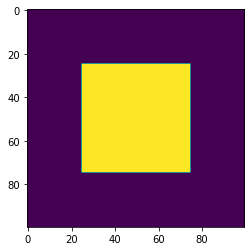

In [135]:
plt.imshow(do_resize(np.ones_like(arr)))

In [733]:
%pdb

Automatic pdb calling has been turned ON


In [750]:
do_forward(x)

tensor([[[[4.6791e-04, 4.5581e-04, 4.1331e-04,  ..., 3.3099e-04,
           4.1331e-04, 4.5581e-04],
          [3.2929e-04, 3.1233e-04, 2.8045e-04,  ..., 2.5971e-04,
           3.0697e-04, 3.3028e-04],
          [7.6540e-05, 6.7093e-05, 8.1178e-05,  ..., 7.0199e-05,
           8.2718e-05, 8.7515e-05],
          ...,
          [4.9072e-05, 7.4506e-05, 6.1123e-05,  ..., 2.1204e-04,
           5.7752e-05, 2.2651e-05],
          [7.6541e-05, 8.7515e-05, 8.2719e-05,  ..., 1.3504e-04,
           8.1177e-05, 6.7093e-05],
          [3.2929e-04, 3.3028e-04, 3.0697e-04,  ..., 2.2778e-04,
           2.8045e-04, 3.1233e-04]]],


        [[[1.1100e-03, 9.8271e-04, 6.5919e-04,  ..., 2.9786e-04,
           6.5919e-04, 9.8271e-04],
          [1.1219e-03, 9.5447e-04, 6.1333e-04,  ..., 2.1285e-04,
           6.0780e-04, 9.8800e-04],
          [1.0848e-03, 1.0064e-03, 6.6471e-04,  ..., 8.1590e-05,
           3.8125e-04, 8.1235e-04],
          ...,
          [8.7594e-04, 4.5448e-04, 1.4526e-04,  ..., 5.04

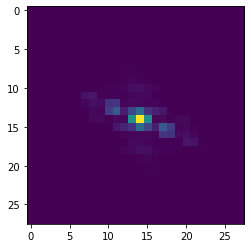

In [65]:
plt.imshow(
    fftshift(power(fft2(x[3][0].numpy()))))

In [706]:
N = 28

In [704]:
(resized * resized).mean()

0.020570649

In [786]:
do_resize(x[0][0]).mean()

tensor(0.0216)

In [143]:
do_forward(x).min()

tensor(0.0002)

In [142]:
x.max()

tensor(1.)

In [722]:
resized.mean()

0.029960735

In [771]:
do_forward(x).shape

torch.Size([16, 1, 28, 28])

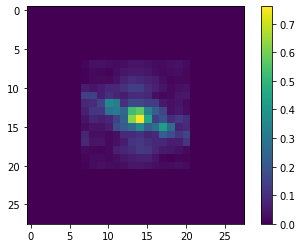

In [164]:
plt.imshow(do_resize(x)[3][0])
plt.colorbar()

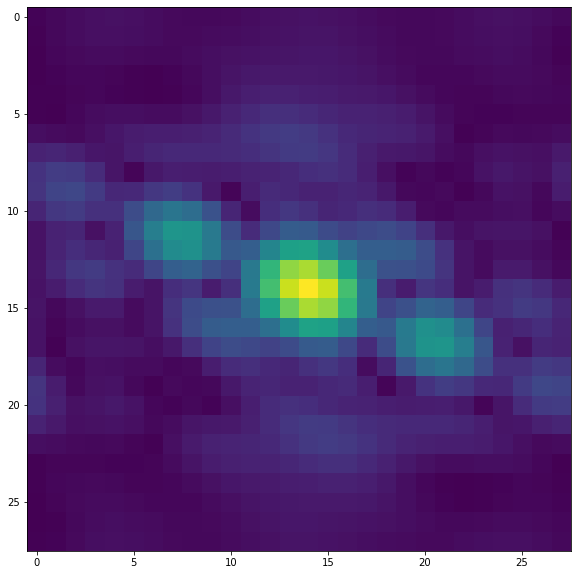

In [866]:
plt.imshow(do_forward(x)[3][0])

In [871]:
torch.__version__

'1.10.2+cu102'

In [868]:
x[3][0].shape

torch.Size([28, 28])

In [870]:
plt.imshow(do_forward(x[3][0]))

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)

> /home/ollie/anaconda3/lib/python3.8/site-packages/torch/nn/modules/pooling.py(616)forward()
    614 
    615     def forward(self, input: Tensor) -> Tensor:
--> 616         return F.avg_pool2d(input, self.kernel_size, self.stride,
    617                             self.padding, self.ceil_mode, self.count_include_pad, self.divisor_override)
    618 

ipdb> c


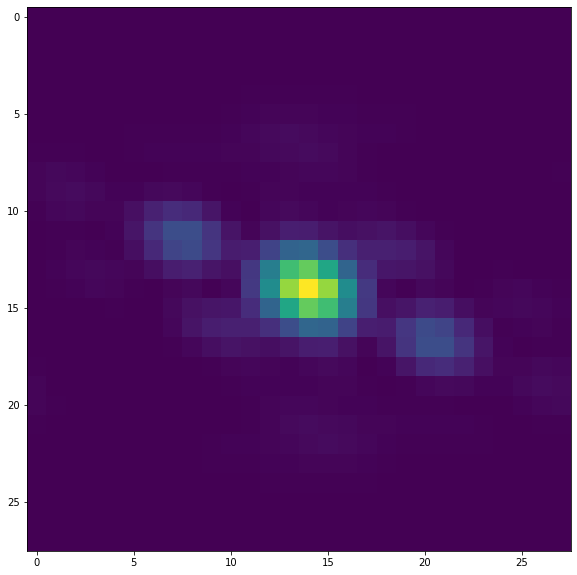

In [769]:
plt.imshow(do_forward(x[3][0]))

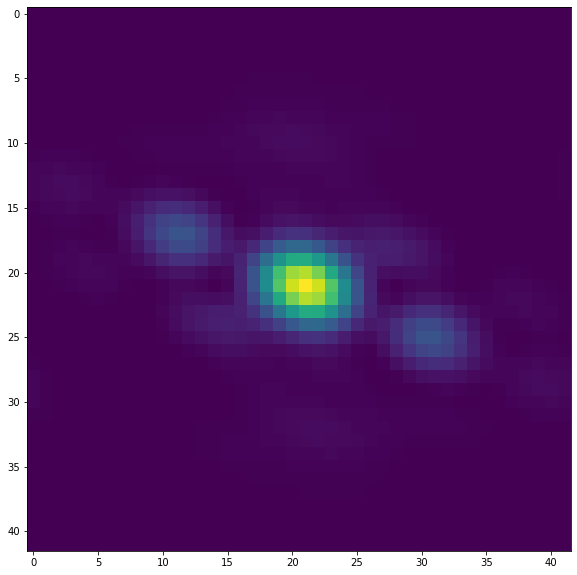

In [752]:
plt.imshow(do_forward(x[3][0]))

In [ ]:
(resized * resized)

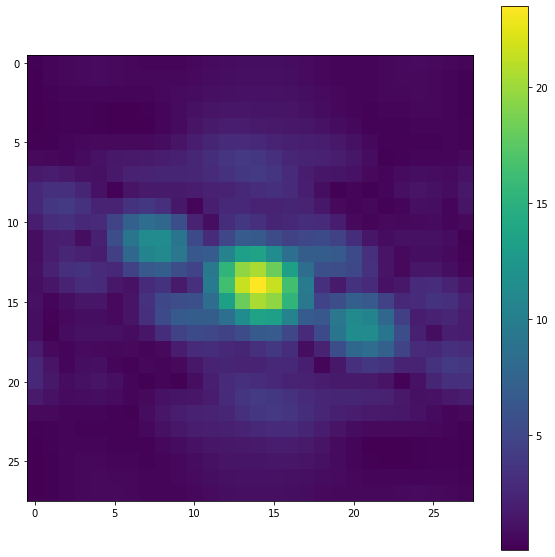

In [700]:
plt.imshow(
    fftshift(
        np.sqrt(power(fft2(resized)))))
plt.colorbar()

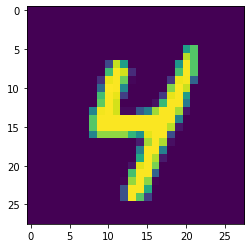

In [66]:
plt.imshow(x[3].reshape((28, 28)).detach().numpy())

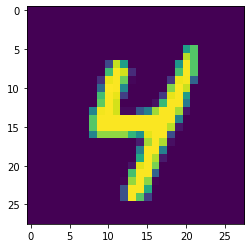

In [130]:
plt.imshow(x[3].reshape((28, 28)).detach().numpy())

In [602]:
plt.imshow(x.cpu()[3].reshape((28, 28)), cmap = 'jet')
plt.colorbar()

RuntimeError: shape '[28, 28]' is invalid for input of size 841

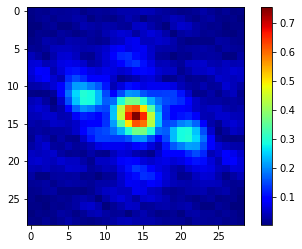

In [608]:
plt.imshow(do_forward(vae.reconstruct_img(x)).cpu().detach().numpy()[3], cmap = 'jet')
plt.colorbar()

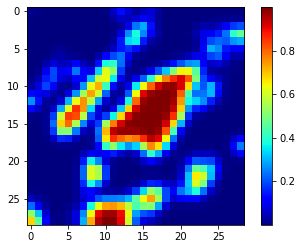

In [613]:
plt.imshow(vae.reconstruct_img(x)[15].reshape((N, N)).cpu().detach().numpy(), cmap = 'jet')
plt.colorbar()

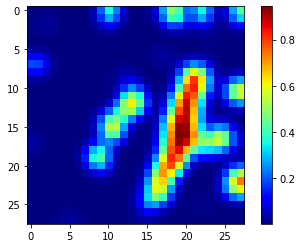

In [456]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).cpu().detach().numpy(), cmap = 'jet')
plt.colorbar()

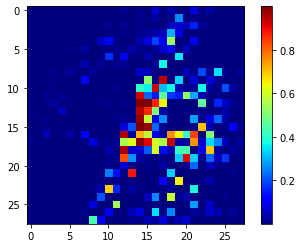

In [351]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

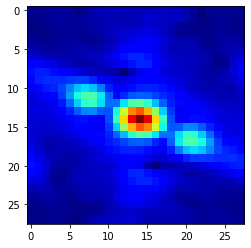

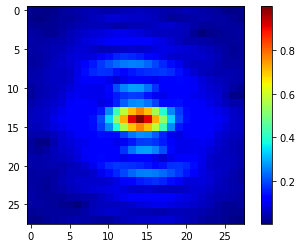

In [317]:
plt.imshow(vae.reconstruct_img(x)[2].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

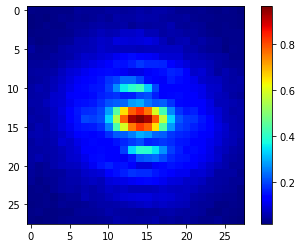

In [300]:
plt.imshow(vae.reconstruct_img(x)[2].reshape((28, 28)).detach().numpy(), cmap = 'jet')
plt.colorbar()

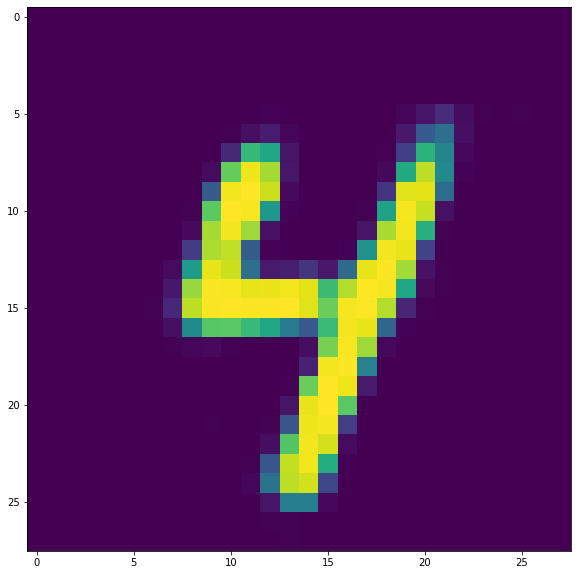

In [671]:
plt.imshow(vae.reconstruct_img(x)[3].reshape((28, 28)).detach().numpy())

In [637]:
# vae.reconstruct_img(x[0])[0].reshape((28, 28)).min()

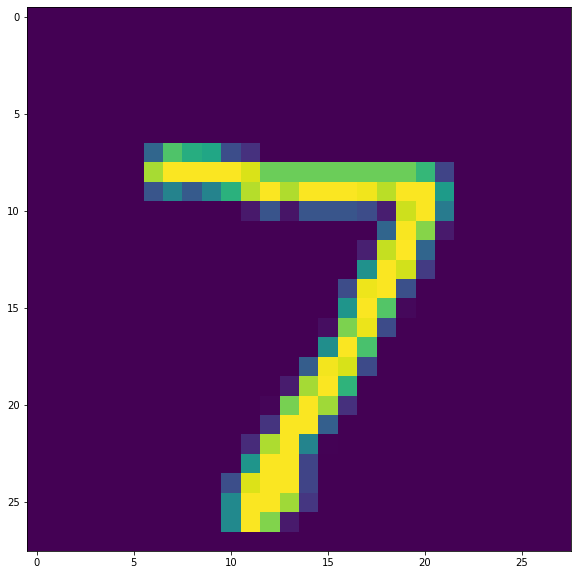

In [638]:
plt.imshow(res[0][0])

In [639]:
test_elbo

[169.84870153808595, 373.8694891296387, 402.4586141204834]

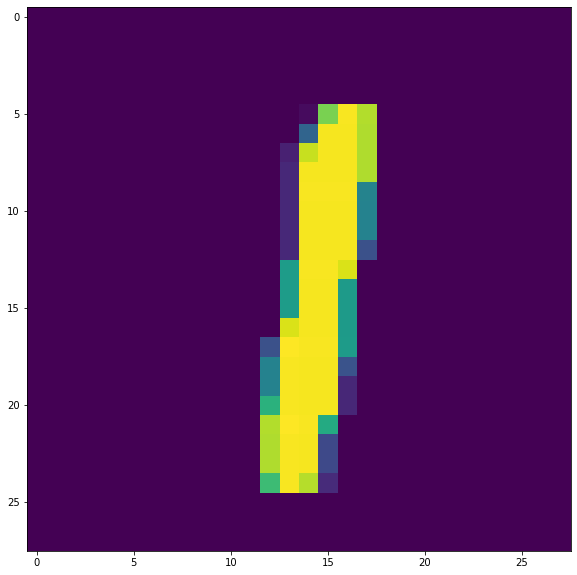

In [640]:
plt.imshow(x[0][0])